In [1]:
#######################
### LOAD IN MODULES ###
#######################

import cv2 # to install on mac: pip install opencv-python
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
from scipy.spatial import procrustes # for Procrustes analysis
from scipy.spatial import ConvexHull # for convex hull
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import matplotlib.pyplot as plt # for plotting
import numpy as np # for using arrays
import math # for mathematical operations
import pandas as pd # for using pandas dataframes
import seaborn as sns # for plotting in seaborn

In [2]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean


# Read in data

In [3]:
########################
### READ IN METADATA ###
########################

mdata = pd.read_csv("./metadata.csv") # read in csv

mdata.head() # head data to check


,file,dataset,px_cm,genotype,node,base_x,base_y,tip_x,tip_y
0,col_lf1.tif,arabidopsis,462,col,1,1029,1539,974.5,461.5
1,col_lf2.tif,arabidopsis,462,col,2,921,1644,995.5,350.5
2,col_lf3.tif,arabidopsis,462,col,3,915,1647,977.5,353.5
3,col_lf4.tif,arabidopsis,462,col,4,1056,1575,953.5,425.5
4,col_lf5.tif,arabidopsis,462,col,5,954,1392,1016.5,608.5


In [4]:
#######################################
### MAKE A LIST OF IMAGE FILE NAMES ###
#######################################

data_dir = "./binary_images/" # set data directory

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

#file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

file_names # check list of file names


['col_lf1.tif',
 'col_lf2.tif',
 'col_lf3.tif',
 'col_lf4.tif',
 'col_lf5.tif',
 'ull_lf1.tif',
 'ull_lf2.tif',
 'ull_lf3.tif',
 'ull_lf4.tif',
 'ull_lf5.tif']

# Place equidistant pseudo-landmarks

- Read in image in grayscale
- Select the contour of the largest object (the leaf)
- Interpolate with a high resolution of pseudo-landmarks
- Find the base and tip index point on the high resolution contour
- Reset the base index to zero
- Interpolate each side with desired number of equidistant pseudo-landmarks
- Rotate leaves and scale to centimeters
- Save pseudo-landmarks scaled to centimeters in an array

PARAMETERS AND INDEXING:
- `high_res_pts` is an arbitrarily high number of points to initially interpolate
- `res` is the desired number of points to interpolate on each side of the leaf
- The total number of pseudo-landmarks will be `2*res - 1`
- The base index will be `0`
- The tip index will be `res-1`
- The returned leaves in `cm_arr` are scaled in size to centimeters

In [5]:
######################
### SET PARAMETERS ###
######################

# the number of equidistant points to create
# an initial high resolution outline of the leaf
high_res_pts = 1000 

# the ultimate number of equidistant points on each side of the leaf
# (-1 for the tip)
# the leaf will have res*2-1 pseudo-landmarks
#################
#################
#################
res = 20 ########
#################
#################
#################

# an array to store pseudo-landmarks
cm_arr = np.zeros((len(mdata),(res*2)-1,2))

# for each leaf . . .
for lf in range(len(mdata)):

    ###############################
    ### READ IN GRAYSCALE IMAGE ###
    ###############################

    curr_image = mdata["file"][lf] # select the current image
    print(lf, curr_image) # print each leaf in case there are problems later

    # read in image
    # convert to grayscale
    # invert the binary
    img = cv2.bitwise_not(cv2.cvtColor(cv2.imread(data_dir + curr_image),cv2.COLOR_BGR2GRAY))

    # find contours of binary objects
    contours, hierarchy = cv2.findContours(img,  
        cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 

    ##############################
    ### SELECT LARGEST CONTOUR ###
    ##############################

    # ideally there is only one leaf in the image
    # in the case there are smaller objects
    # this code selects the largest object (the leaf)
    # if there is one and only one object in the image
    # then the following code is not necessary

    x_conts = [] # list of lists of contour x vals
    y_conts = [] # list of lists of contour y vals
    areas_conts = [] # list of bounding box areas of contours
    for c in contours: # for each contour
        x_vals = [] # store x vals for current contour 
        y_vals = [] # store y vals for current contour
        for i in range(len(c)): # for each point in current contour
            x_vals.append(c[i][0][0]) # isolate x val
            y_vals.append(c[i][0][1]) # isolate y val
        area = (max(x_vals) - min(x_vals))*(max(y_vals) - min(y_vals)) # calculate bounding box area of contour
        x_conts.append(x_vals) # append the current contour x vals
        y_conts.append(y_vals) # append the current contour y vals
        areas_conts.append(area) # append the current contour bounding box areas

    area_inds = np.flip(np.argsort(areas_conts)) # get indices to sort contours by area
    sorted_x_conts = np.array(x_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, x vals
    sorted_y_conts = np.array(y_conts, dtype=object)[area_inds][0:] # areas sorted largest to smallest, y vals

    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaf to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(sorted_x_conts[0].astype(np.float32), 
                                           sorted_y_conts[0].astype(np.float32), high_res_pts)

    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    # get the base and tip landmark point values
    base_pt = np.array((mdata["base_x"][lf], mdata["base_y"][lf]))
    tip_pt = np.array((mdata["tip_x"][lf], mdata["tip_y"][lf]))

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)

    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaf coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))

    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaf
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))

    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))

    # scale leaf into cm
    cm_lf = rot_pts/(mdata["px_cm"][lf])
    
    # store the leaf scaled into cm into the cm_arr
    cm_arr[lf,:,:] = cm_lf

0 col_lf1.tif
1 col_lf2.tif
2 col_lf3.tif
3 col_lf4.tif
4 col_lf5.tif
5 ull_lf1.tif
6 ull_lf2.tif
7 ull_lf3.tif
8 ull_lf4.tif
9 ull_lf5.tif


#### *(plot is only for example, remove for real analysis)*

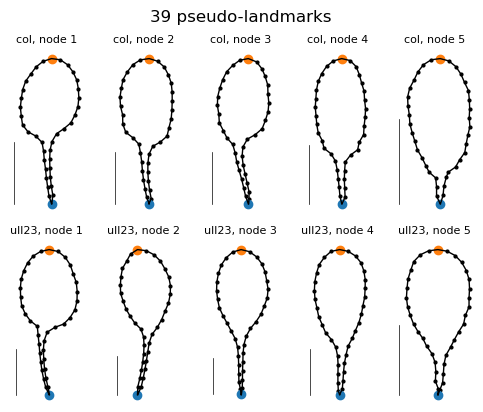

In [6]:
# Plot each leaf and check that it is working
# (remove this when working with a large number of leaves outside of this example)

plt.figure(figsize=(5,10))

for i in range(len(cm_arr)):
    
    plt.subplot(5,5,i+1)
    plt.plot(cm_arr[i,:,0], cm_arr[i,:,1], c="k", lw=1)
    plt.plot([min(cm_arr[i,:,0])-0.1,min(cm_arr[i,:,0])-0.1],
            [cm_arr[i,0,1], cm_arr[i,0,1]+1], c="k", lw=0.5) # cm scale
    plt.scatter(cm_arr[i,:,0], cm_arr[i,:,1], c="k", s=4)
    plt.scatter(cm_arr[i,0,0], cm_arr[i,0,1])
    plt.scatter(cm_arr[i,res-1,0], cm_arr[i,res-1,1])
    
    plt.title(mdata["genotype"][i]+", node "+str(mdata["node"][i]), fontsize=8)
    
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
plt.suptitle(str(res*2-1) + " pseudo-landmarks")
plt.tight_layout()

# Analyze leaf dimensions

Using placed pseudo-landmarks representing leaves that are rotated upwards and scaled in centimeters from `cm_arr`, calculate the following:

- `width`: difference in centimeters between minimum and maximum x values in an oriented leaf
- `length`: difference in centimeters between minimum and maximum y values in an oriented leaf
- `area`: area of the leaf in centimeters squared
- `solidity`: the ratio of area to convex hull area
- `asymmetry`: the Procrustes distance between the superimposed left and right sides of a leaf outline. Lower values are more symmetric. Higher values are more asymmetric.  

Data is stored in the `mdata` dataframe.

In [7]:
# lists to store variables
width_list = []
length_list = []
area_list = []
solidity_list = []
asymmetry_list = []

# for each leaf . . .
for lf in range(len(cm_arr)):
    
    # for calculating dimensions, we need non-scaled leaves in centimeters
    curr_lf = cm_arr[lf,:,:] # select current leaf
    
    ############################
    ### CALCULATE DIMENSIONS ###
    ############################
    
    width = np.max(curr_lf[:,0])-np.min(curr_lf[:,0]) # calculate width
    length = np.max(curr_lf[:,1])-np.min(curr_lf[:,1]) # calculate length
    area = poly_area(curr_lf[:,0],curr_lf[:,1]) # calcualte area
    
    ##########################
    ### CALCULATE SOLIDITY ###
    ##########################
    
    hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
    vertices = hull.vertices # isolate vertex indices of convex hull
    convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
    solidity = area / convex_area # calculate solidity
    
    ##########################
    ### CALCULATE SYMMETRY ###
    ##########################
    
    left_side = curr_lf[:(res-1)+1,] # isolate left side of leaf
    right_side = curr_lf[(res-1):,] # isolate right side of leaf
    right_side = right_side[::-1] # reverse the right side to align indices with left

    # calculate procrustes distance between left and right side of leaf
    s1, s2, distance = procrustes(left_side, right_side) 
    
    # store data in lists
    width_list.append(width)
    length_list.append(length)
    area_list.append(area)
    solidity_list.append(solidity)
    asymmetry_list.append(distance)
    
# add data to the mdata dataframe
mdata["width"] = width_list
mdata["length"] = length_list
mdata["area"] = area_list
mdata["solidity"] = solidity_list
mdata["asymmetry"] = asymmetry_list
    

#### Pair plots of dimensions and other data

/Users/chitwoo9/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


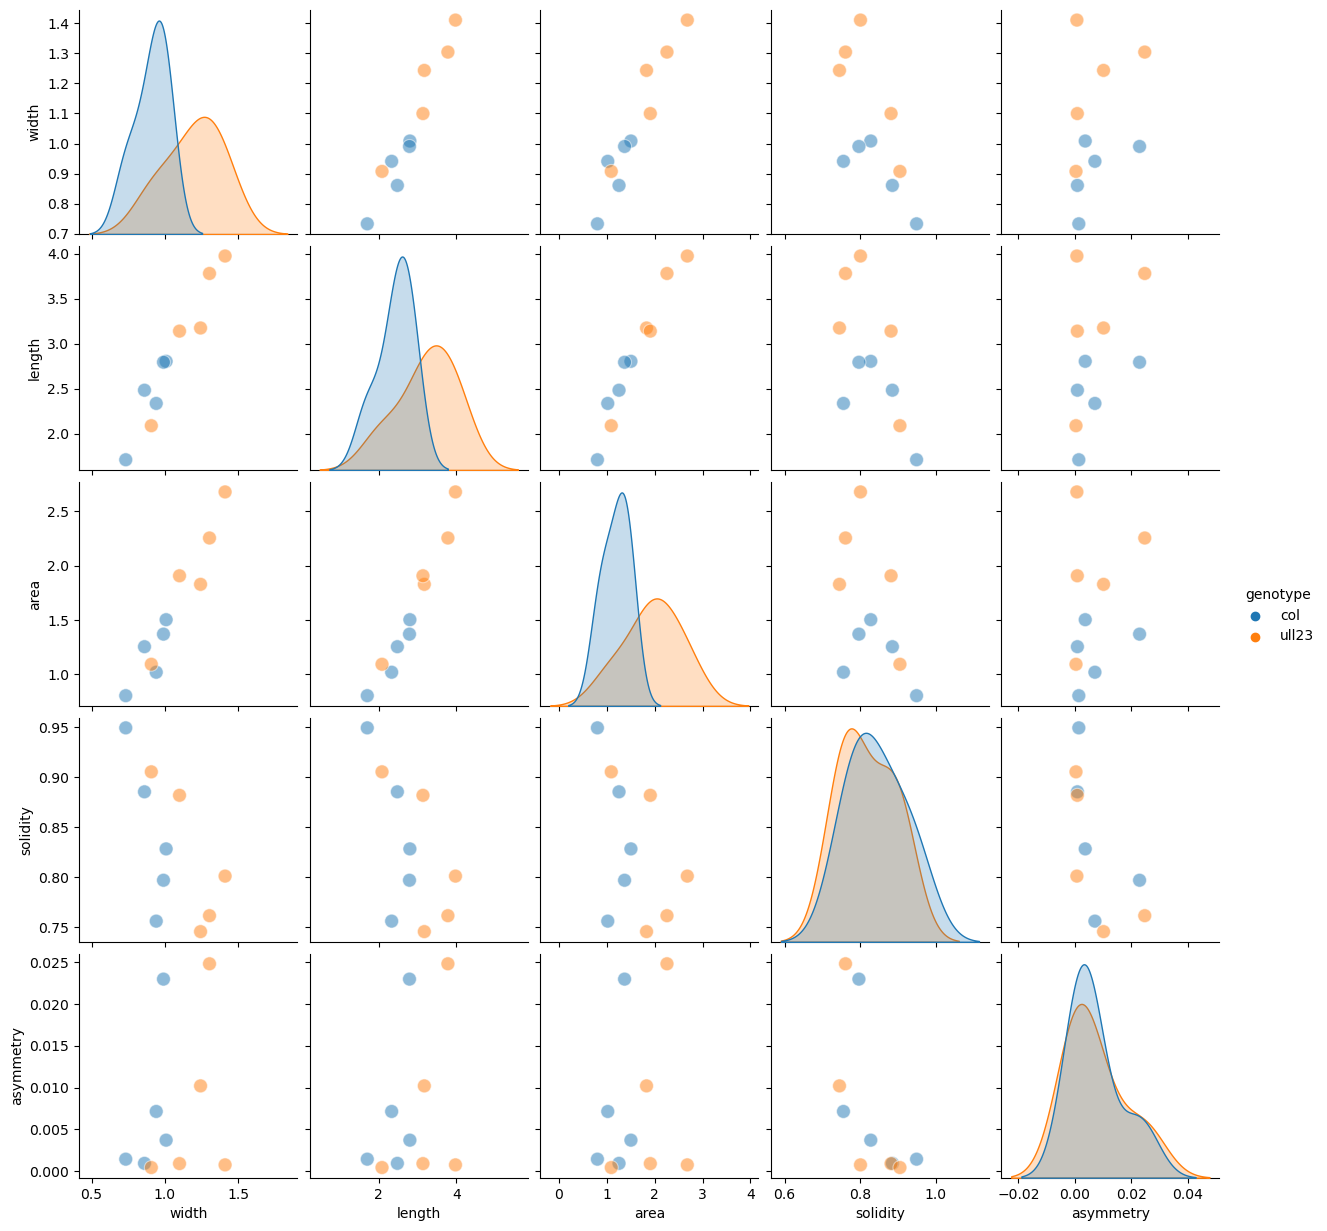

In [8]:
sns.pairplot(mdata,
             x_vars=["width", "length", "area","solidity","asymmetry"],
             y_vars=["width", "length", "area","solidity","asymmetry"],
             hue="genotype",
             plot_kws={"s": 100, "alpha":0.5, "lw":0}
            )

/Users/chitwoo9/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


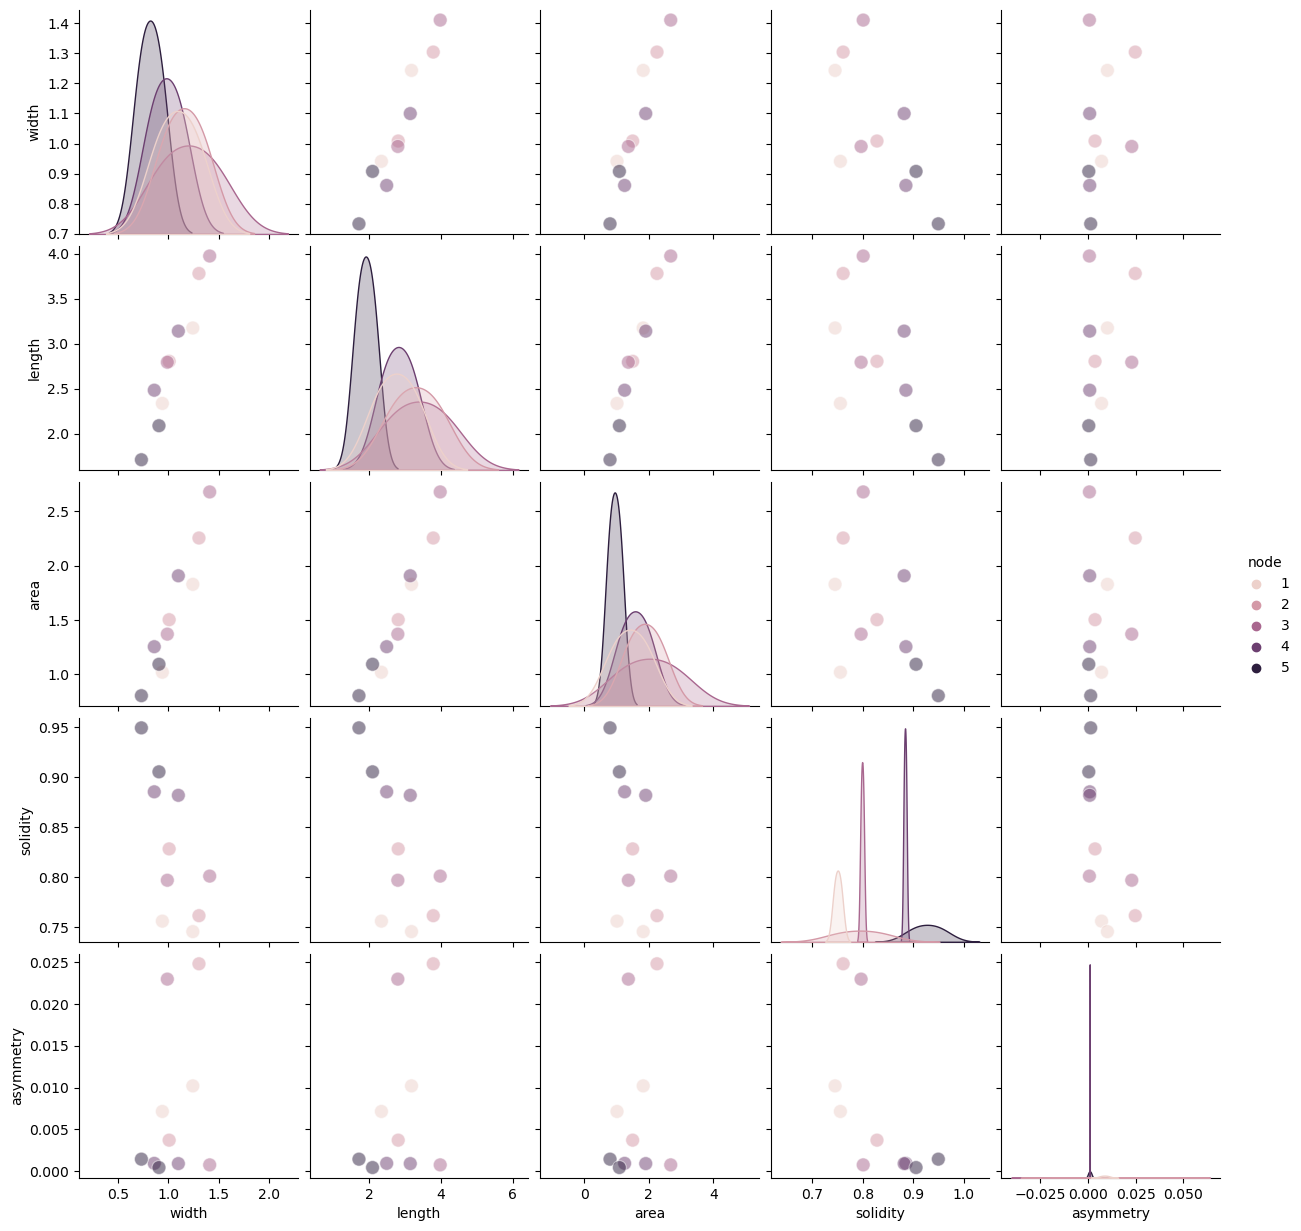

In [9]:
sns.pairplot(mdata,
             x_vars=["width", "length", "area","solidity","asymmetry"],
             y_vars=["width", "length", "area","solidity","asymmetry"],
             hue="node",
             plot_kws={"s": 100, "alpha":0.5, "lw":0}
            )

# Procrustes analysis

Perform a Procrustes analysis to translate, scale, and rotate leaf shapes

- Select number of pseudo-landmarks and dimensions
- Calculate the GPA mean leaf shape using the `gpa_mean` function
- Align all leaves to the GPA mean
- Store Procrustes super-imposed leaves in an array, `proc_arr`
- Calculate a PCA for all possible axes and their variance (the number of leaves)
- Calculate a PCA for just the axes needed for reconstruction of eigenleaves for morphospace (probably 2)

In [10]:
landmark_num = (res*2)-1 # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(cm_arr, landmark_num, dim_num)

################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(cm_arr)) 

for i in range(len(cm_arr)):
    s1, s2, distance = procrustes(mean_shape, cm_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

In [11]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = np.shape(proc_arr)[0] # PC number = number of leaves
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )


PC: var, overall 
PC1: 55.0%, 55.0%
PC2: 27.9%, 82.9%
PC3: 8.0%, 90.9%
PC4: 3.0%, 93.9%
PC5: 2.3%, 96.2%
PC6: 1.6%, 97.8%
PC7: 1.4%, 99.1%
PC8: 0.8%, 99.9%
PC9: 0.1%, 100.0%
PC10: 0.0%, 100.0%


In [12]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 2 # PC number = 2, for limiting to 2 axes for morphospace reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# add PCs to dataframe for plotting
mdata["PC1"] = PCs[:,0]
mdata["PC2"] = PCs[:,1]
    

PC: var, overall 
PC1: 55.0%, 55.0%
PC2: 27.9%, 82.9%


# Morphospace and Linear Discriminant Analysis by genotype

Visualize a morphospace and classify leaves by the factor of genotype

- Plot a morphospace using the inverse transform of the PCA
- Perform a Linear Discriminant Analysis
- Visualize LDA results as a confusion matrix
- Plot out LDA scores
- Note: the number of LDs is 1 minus the number of factor levels. In this example there are two genotypes, so there is only 1 LD
- Note: the column names to plot the Linear Discriminants are manually renamed

Text(0.5, 1.0, 'Procrustean morphospace')

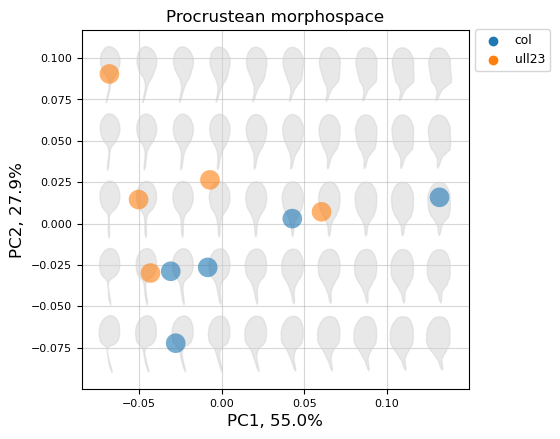

In [13]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 5 # plot length in inches
plot_width= 5 # plot length in inches
numPC1 = 10 # set number of PC1 intervals
numPC2 = 5 # set number of PC2 intervals
hue = "genotype" # select the factor to color by
s = 0.07 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 200 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pc1_val, inv_y*s+pc2_val, c=lf_col, alpha=lf_alpha)
   
# plot the data on top of the morphospace
sns.scatterplot(data=mdata, x="PC1", y="PC2", hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.grid(alpha=grid_alpha)
plt.gca().set_axisbelow(True)
plt.title(title)

The number of falsely predicted: 0
The number of correctly predicted: 10
Out of 10 total samples


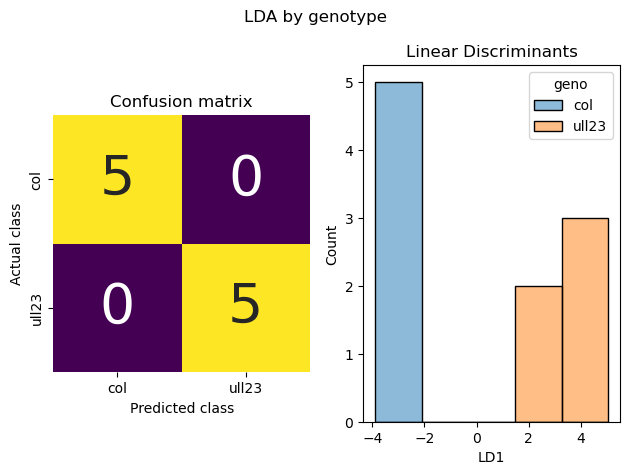

In [14]:
##################################################
### PERFORM LINEAR DISCRIMINANT ANALYSIS (LDA) ###
##################################################

# create a df for LDA by genotype
geno_df = pd.DataFrame(data=flat_arr[:,:])

# add the genotype labels
geno_df["geno"] = mdata["genotype"]

# create input and output variables
X = geno_df.iloc[:,0:((res*2)-1)*2]
y = geno_df["geno"]

# fit the LDA model
geno_model = LinearDiscriminantAnalysis()
geno_model.fit(X,y)

# retrieve LDA scalings and coefficients
geno_scalings = geno_model.scalings_
geno_coefs = geno_model.coef_

# perform prediction
geno_prediction= geno_model.predict(X)
comparison_result = [X == y for X, y in zip(y, geno_prediction)]

# print out number of correctly predicted results
count_true_pl = comparison_result.count(True)
count_false_pl = comparison_result.count(False)
print("The number of falsely predicted:", count_false_pl)
print("The number of correctly predicted:", count_true_pl)
print("Out of " + str(len(comparison_result)) + " total samples" )

# Create confusion matrix
true_geno_values = mdata["genotype"]
predicted_geno_values = geno_prediction

cm_geno = confusion_matrix(true_geno_values, predicted_geno_values)

classes = mdata["genotype"].unique()

# First subplot: confusion matrix
ax1 = plt.subplot(1,2,1)
ax1 = sns.heatmap(cm_geno, annot=True, annot_kws={"fontsize":40}, fmt="d", cmap="viridis", square=True, cbar=False,xticklabels=classes,yticklabels=classes)
ax1 = plt.title("Confusion matrix")
ax1 = plt.xlabel("Predicted class")
ax1 = plt.ylabel("Actual class")

# Second subplot: plot of linear discriminant scores
plt.subplot(1,2,2)
data_plot = geno_model.fit(X, y).transform(X)
geno_plot_df = pd.DataFrame(data=data_plot[:,:])
geno_plot_df["geno"] = mdata["genotype"]
# NOTE: COLUMN NAMES ARE MANUALLY RENAMED
geno_plot_df = geno_plot_df.rename(columns={0:'LD1'})
sns.histplot(data=geno_plot_df, x="LD1", hue="geno")
plt.title("Linear Discriminants")

plt.suptitle("LDA by genotype")
plt.tight_layout()

# Morphospace and Linear Discriminant Analysis by development

Visualize a morphospace and classify leaves by the factor of node

- Plot a morphospace using the inverse transform of the PCA
- Perform a Linear Discriminant Analysis
- Note: for LDA, must model `node` as a categorical variable of continuous data
- Visualize LDA results as a confusion matrix
- Plot out LDA scores
- Note: the number of LDs is 1 minus the number of factor levels. In this example there are five, so there is 4 lienar discriminants
- Note: the column names to plot the Linear Discriminants are manually renamed

Text(0.5, 1.0, 'Procrustean morphospace')

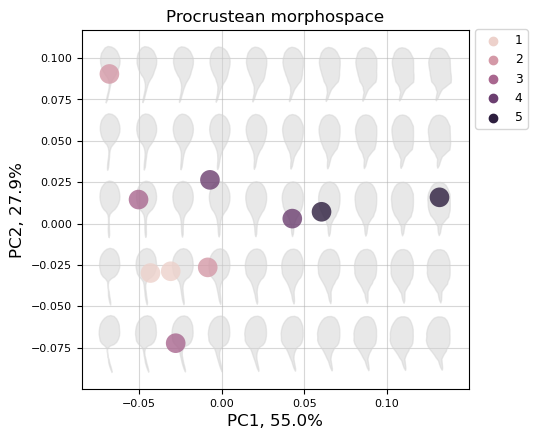

In [15]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 5 # plot length in inches
plot_width= 5 # plot length in inches
numPC1 = 10 # set number of PC1 intervals
numPC2 = 5 # set number of PC2 intervals
hue = "node" # select the factor to color by
s = 0.07 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 200 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.8 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pc1_val, inv_y*s+pc2_val, c=lf_col, alpha=lf_alpha)
   
# plot the data on top of the morphospace
sns.scatterplot(data=mdata, x="PC1", y="PC2", hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.grid(alpha=grid_alpha)
plt.gca().set_axisbelow(True)
plt.title(title)

The number of falsely predicted: 1
The number of correctly predicted: 9
Out of 10 total samples


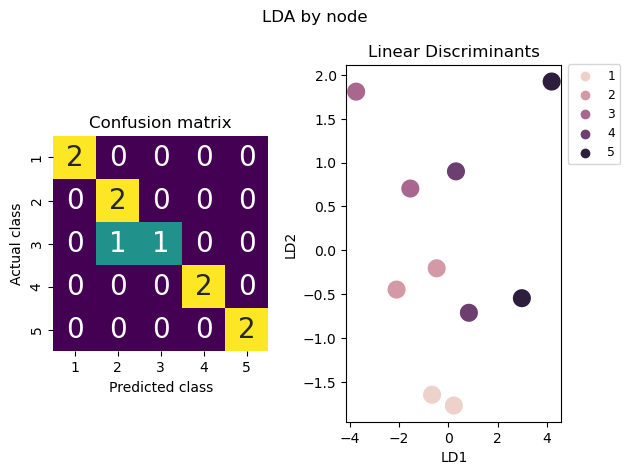

In [16]:
##################################################
### PERFORM LINEAR DISCRIMINANT ANALYSIS (LDA) ###
##################################################

# create a df for LDA by genotype
node_df = pd.DataFrame(data=flat_arr[:,:])

# add the node labels
# convert to a categorical variable
node_df["node"] = mdata["node"].astype(str)

# create input and output variables
X = node_df.iloc[:,0:((res*2)-1)*2]
y = node_df["node"]

# fit the LDA model
node_model = LinearDiscriminantAnalysis()
node_model.fit(X,y)

# retrieve LDA scalings and coefficients
node_scalings = node_model.scalings_
node_coefs = node_model.coef_

# perform prediction
node_prediction= node_model.predict(X)
comparison_result = [X == y for X, y in zip(y, node_prediction)]

# print out number of correctly predicted results
count_true_pl = comparison_result.count(True)
count_false_pl = comparison_result.count(False)
print("The number of falsely predicted:", count_false_pl)
print("The number of correctly predicted:", count_true_pl)
print("Out of " + str(len(comparison_result)) + " total samples" )

# Create confusion matrix
true_node_values = mdata["node"].astype(str)
predicted_node_values = node_prediction

cm_node = confusion_matrix(true_node_values, predicted_node_values)

classes = mdata["node"].unique()

# First subplot: confusion matrix
ax1 = plt.subplot(1,2,1)
ax1 = sns.heatmap(cm_node, annot=True, annot_kws={"fontsize":20}, fmt="d", cmap="viridis", square=True, cbar=False,xticklabels=classes,yticklabels=classes)
ax1 = plt.title("Confusion matrix")
ax1 = plt.xlabel("Predicted class")
ax1 = plt.ylabel("Actual class")

# Second subplot: plot of linear discriminant scores
plt.subplot(1,2,2)
data_plot = node_model.fit(X, y).transform(X)
node_plot_df = pd.DataFrame(data=data_plot[:,:])
node_plot_df["node"] = mdata["node"]
# NOTE: COLUMN NAMES ARE MANUALLY RENAMED
node_plot_df = node_plot_df.rename(columns={0:'LD1',
                                           1:'LD2',
                                           2:'LD3',
                                           3:'LD4',})
# NOTE: POINT SIZES AND LEGEND POSITION ARE MANUALLY PROVIDED
sns.scatterplot(data=node_plot_df, x="LD1", y="LD2", hue="node", s=200)
plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
plt.title("Linear Discriminants")

plt.suptitle("LDA by node")
plt.tight_layout()

# Genetic analysis

For the purposes of genetic analysis, we would like to measure the Euclidean distance of 1) each landmark point of 2) each leaf to the overall mean leaf.  

The code below is an example of how to do this. You will need two things to calculate this, both of which are found in the code above: 

1.  The Generalized Procrustes Analysis (GPA) mean leaf. This is stored in the array `mean_shape` above. It was calcualted using the `gpa_mean` function.
2.  All leaves aligned to the GPA mean by Procrustes superimposition. This is the array `proc_arr` above.

Before we do that though, let's plot all the Procrustes superimposed leaves on top of each other and the mean leaf on top of that, just to make sure we are dealing with the right data. This can also be an explanation of arrays. The array `proc_arr` is what we call a "3D array". We can measure the shape of any array with the function `np.shape`. We see below that the `proc_arr` has a shape of 10 x 39 x 2, which corresponds to 10 leaves, 39 landmarks, 2 coordinate values. We can access each dimension value from `np.shape` using indexing (the first will be `[0]`, the second `[1]`, and the third `[2]`). We can use these dimensions later in our loops to know how many elements to loop through.

In [17]:
# let's get the dimensions of the proc_arr
print("The overall dimensions are: ", np.shape(proc_arr))

# let's get each dimension
print("The first dimension is: ", np.shape(proc_arr)[0])
print("The second dimension is: ", np.shape(proc_arr)[1])
print("The third dimension is: ", np.shape(proc_arr)[2])

The overall dimensions are:  (10, 39, 2)
The first dimension is:  10
The second dimension is:  39
The third dimension is:  2


The `mean_shape` is only a 2D array, because it represents only one leaf. It's dimensions are 39 landmarks by 2 coordinate values.

We can write a `for` loop below in which we plot each leaf on top of each other by using indexing of the first position of the 3D `proc_arr`. Outside of the loop, we can then plot the `mean_shape` on top of that.

(-0.1107039065153783,
 0.1101379648975669,
 -0.2788366365090959,
 0.2632968464168807)

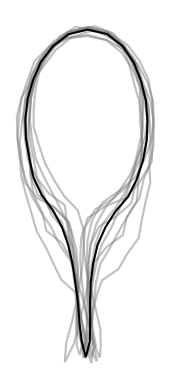

In [18]:
for lf in range(np.shape(proc_arr)[0]): # for each leaf "lf" for the length of the array proc_arr
    
    plt.plot(proc_arr[lf,:,0], proc_arr[lf,:,1], alpha=0.5, c="gray") # plot each leaf
    plt.gca().set_aspect("equal") # set the aspect ratio of the axes equal
    
plt.plot(mean_shape[:,0], mean_shape[:,1], c="black") # plot the mean leaf
plt.axis("off") # remove axes for visualization

Now, let's calculate the Euclidean distance of each point of each leaf to the mean leaf.

We will need an empty array to store the data. Below, we create `euclid_arr` to store the data using the `np.zeros` function. Look how `np.shape` builds the shape of `euclid_arr` using the dimensions of `proc_arr`.

Then, we will use a double loop, that for 1) each leaf and for 2) each point on each of those leaves, we calculate the Euclidean distance to the corresponding point on the mean leaf. We store the data in `euclid_arr`. Look at how indexing of arrays is used to achieve this below...

***UPDATE 8 July 2024:*** We also need to provide a sign to the Euclidean distance value. If the point lies outside of the polygon of the mean shape it will be positive. If it lies inside the polygon of the mean shape it will be negative. We will use the `shapely` module to test if the point lies inside or outside the polygon of the mean shape. You can import the module `shapely` in the cell below.

In [23]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [29]:
# convert the mean shape into a shapely polygon object
shapely_polygon = Polygon(mean_shape)

# an array to store the Euclidean distance of each point of each leaf to the mean leaf
euclid_arr = np.zeros((
    np.shape(proc_arr)[0], # the first dimension is the number of leaves
    np.shape(proc_arr)[1] # the second dimension is the number of landmark points
))

for lf in range(np.shape(proc_arr)[0]): # for each leaf "lf"
    
    for pt in range(np.shape(proc_arr)[1]): # then, for that leaf, each point "pt"
        
        x1 = mean_shape[pt,0] # x1 is the x value of point pt for the mean shape
        y1 = mean_shape[pt,1] # y1 is the y value of point pt for the mean shape
        
        x2 = proc_arr[lf,pt,0] # x2 is the x value of leaf lf of point pt from proc_arr
        y2 = proc_arr[lf,pt,1] # y2 is the y value of leaf lf of point pt from proc_arr
        
        shapely_point = Point(x2, y2) # convert point to Shapely point object
        
        d = euclid_dist(x1, y1, x2, y2) # calculate the Euclidean distance d
        
        if shapely_polygon.contains(shapely_point): # if the mean shape contains the point
            d = -d # then the point is inside the mean shape and it should be negative
        else:
            d = d # else the point is outside the mean shape and it should remain positive
        
        euclid_arr[lf,pt] = d # store the distance value in the lf, pt position of the euclid_arr
        
# take a look at the shape/dimensions of euclid_arr
print(np.shape(euclid_arr))


(10, 39)


***UPDATE 8 July 2024:*** Plot out a selected leaf against the mean leaf and color the points by their distance to make sure negative points are inside the mean and positive points are outside.

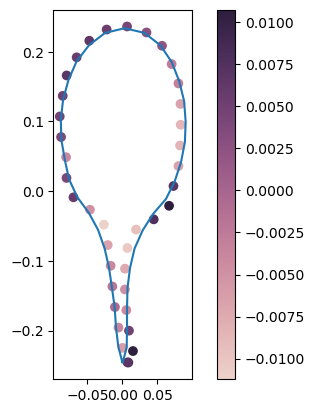

In [61]:
# look at one of the leaves to make sure it worked

i = 1 # select a leaf by index
cmap = sns.cubehelix_palette(as_cmap=True) # set a color map

# plot the selected leaf
# DOUBLE CHECK THAT NEGATIVE VALUES ARE INSIDE MEAN
# AND THAT POSITIVE VALUES ARE OUTSIDE MEAN
plt.scatter(proc_arr[i,:,0], proc_arr[i,:,1], c=euclid_arr[i], cmap=cmap) # plot the leaf colored by euclidean distance
plt.plot(mean_shape[:,0], mean_shape[:,1]) # plot the mean shape
plt.gca().set_aspect("equal") # set aspect to equal
plt.colorbar() # add a color legend


You can save `euclid_arr` directly as a `.csv` file using the `np.savetxt` function.

In [62]:
np.savetxt("euclidean_distances.csv", euclid_arr, delimiter=",")

But maybe you want to save the Euclidean distances with associated identifying information. If you have a metadata file (`mdata` in this example) that has the same number of samples, you can 1) convert your numpy array into a pandas dataframe, 2) concatenate along the column axis (axis = 1) with the metadata file, and then 3) save the resulting file.

In [63]:
# convert the array to a dataframe
euclid_df = pd.DataFrame(euclid_arr)

# merge with the meta data dataframe
concatenated_df = pd.concat([mdata, euclid_df], axis=1)

# save the concatenated dataframe with identifying meta data and your Euclidean distances
concatenated_df.to_csv("euclid_dist_df.csv", index=False)


So that is how you calculate the Euclidean distance of each point to the mean! You would export these values and perform genetic analyses. What if from these analyses you wanted to visualize the attributes of specific points on the mean leaf, like the heritability of each point? We don't have heritabilities, but let's calculate the variance of each point across leaves as an example.

In [64]:
variances = [] # a list to store variance across leaves for each point

for pt in range(np.shape(proc_arr)[1]): # for each point "pt"
    
    variances.append(np.var(euclid_arr[:,pt])) # calculate the variance for each point across leaves and store in list
    

It will be easier to plot the variance of each point as a color on the mean leaf using the `hue` option of another plotting module called `seaborn`. But `seaborn` works with dataframes. In real life, you would probably read in the values you would plot onto the leaf as a pandas dataframe anyways (like heritability values, for example). So let's combine the array `mean_shape` with our list `variances` into a dataframe and then plot with `seaborn`.

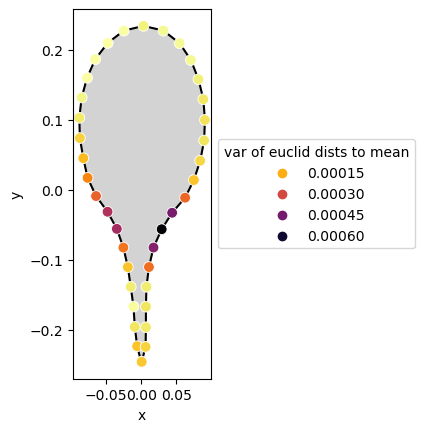

In [65]:
plotting_df = pd.DataFrame(mean_shape, columns=["x","y"]) # convert the mean_shape array into a pandas dataframe

plotting_df["var"] = variances # add the list variances as a column to the dataframe

sns.scatterplot(data=plotting_df, x="x", y="y", hue="var", palette="inferno_r", s=60) # plot
plt.fill(mean_shape[:,0], mean_shape[:,1], c="lightgray", zorder=0) # gray background
plt.plot(mean_shape[:,0], mean_shape[:,1], zorder=0, c="k")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="var of euclid dists to mean") # put legend outside of plot
plt.gca().set_aspect("equal") # set axis to equal aspect ratio

***UPDATE 8 July 2024:*** We want to only look at points that have a variance above a threshold level.

1) Look at a histogram to make an informed decision about the threshold level to choose.
2) Select a threshold level
3) Using a for loop, find indices of points below threshold to discard and equal to or greater than to keep
4) In the pandas dataframe, the point Euclidean distances column names reflect the point INDICES (remember, they start on zero)
5) We find the column index that the first ("0") point begins on, and add that to the point indices to drop
6) We drop the columns of the dataframe and check that it is correct before saving to file

First, look at the column names of the dataframe. Note that the points are indicated by their INDICES (the first point is "0")

In [71]:
concatenated_df.columns

Index([     'file',   'dataset',     'px_cm',  'genotype',      'node',
          'base_x',    'base_y',     'tip_x',     'tip_y',     'width',
          'length',      'area',  'solidity', 'asymmetry',       'PC1',
             'PC2',           0,           1,           2,           3,
                 4,           5,           6,           7,           8,
                 9,          10,          11,          12,          13,
                14,          15,          16,          17,          18,
                19,          20,          21,          22,          23,
                24,          25,          26,          27,          28,
                29,          30,          31,          32,          33,
                34,          35,          36,          37,          38],
      dtype='object')

Next, plot a histogram of the variances to make an informed decision of the threshold variance to drop points

(array([8., 8., 5., 3., 5., 0., 0., 1., 0., 2., 2., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([3.93352037e-05, 5.96949416e-05, 8.00546794e-05, 1.00414417e-04,
        1.20774155e-04, 1.41133893e-04, 1.61493631e-04, 1.81853369e-04,
        2.02213107e-04, 2.22572844e-04, 2.42932582e-04, 2.63292320e-04,
        2.83652058e-04, 3.04011796e-04, 3.24371534e-04, 3.44731272e-04,
        3.65091010e-04, 3.85450747e-04, 4.05810485e-04, 4.26170223e-04,
        4.46529961e-04, 4.66889699e-04, 4.87249437e-04, 5.07609175e-04,
        5.27968912e-04, 5.48328650e-04, 5.68688388e-04, 5.89048126e-04,
        6.09407864e-04, 6.29767602e-04, 6.50127340e-04]),
 <BarContainer object of 30 artists>)

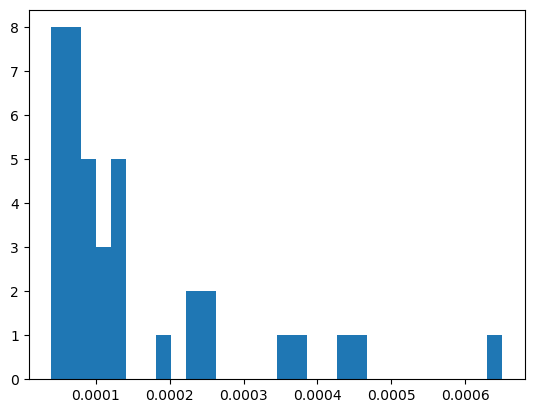

In [68]:
plt.hist(variances, bins=30)

Select the threshold variance you want to use

In [72]:
# select threhold variance value
# only values greater than or equal to will be selected
threshold = 0.0003 

Using a for loop, find the point indices you wish to discard and those you want to keep

In [86]:
inds_below_var = [] # a list to store point indices BELOW the threshold value
inds_to_keep = [] # a list to store the point indices >= threshold values to KEEP

for v in range(len(variances)): # for each variance value
    if variances[v] < threshold: # if the current variance is less than the threshold
        inds_below_var.append(v) # then append the point index to the list
    else:
        inds_to_keep.append(v)
        
        

Look at the pandas dataframe again. We want to find the index of the column of the first point (which is named "0")

In [87]:
# look at the pandas dataframe with euclidean distances
# find the index where the first point starts
concatenated_df.columns

Index([     'file',   'dataset',     'px_cm',  'genotype',      'node',
          'base_x',    'base_y',     'tip_x',     'tip_y',     'width',
          'length',      'area',  'solidity', 'asymmetry',       'PC1',
             'PC2',           0,           1,           2,           3,
                 4,           5,           6,           7,           8,
                 9,          10,          11,          12,          13,
                14,          15,          16,          17,          18,
                19,          20,          21,          22,          23,
                24,          25,          26,          27,          28,
                29,          30,          31,          32,          33,
                34,          35,          36,          37,          38],
      dtype='object')

Find the index of the first point by name (again, the name is `0`)

In [88]:
# we can retrieve the index of the column where the first point starts
# by looking for "0"

zero_pt_index = concatenated_df.columns.get_loc(0)

Add the index of the first point to the indices of the points you want to drop. These will be the column indices of the dataframe we want to drop

In [89]:
# we add the index of the first point (zero)
# to the indices of the points we want to drop
# so that we can drop the desired columns from the dataframe
# REMEMBER: convert list to array so you can add the zero pt index value

drop_cols_inds = np.array(inds_below_var) + zero_pt_index

Drop the indices of the dataframe and save as a new dataframe

In [90]:
# drop the columns of the point indices you want to discard
final_df = concatenated_df.drop(concatenated_df.columns[drop_cols_inds], axis=1)

Look at the column names to make sure everything is right

In [92]:
# look at column names of dataframe to double check

final_df.columns

Index([     'file',   'dataset',     'px_cm',  'genotype',      'node',
          'base_x',    'base_y',     'tip_x',     'tip_y',     'width',
          'length',      'area',  'solidity', 'asymmetry',       'PC1',
             'PC2',           7,           8,          30,          31,
                32],
      dtype='object')

Double check against the indices you should keep

In [93]:
# compare to indices you wanted to keep

inds_to_keep

[7, 8, 30, 31, 32]

If everything looks right, then save the dataframe as a csv. It should only have the most variable points you want to run GWAS on

In [95]:
# save the data frame with only the most variable points
final_df.to_csv("euclid_dist_df.csv", index=False)